# TPC-C Multi-Tenant with Distributed PVC and Tuned MySQL 8.4

* data is generated and loaded into databases in a distributed filesystem
* experiments do not use preloaded data

* PostgreSQL uses improved args:
```
  - "--local-infile=1"
  # --- I/O Threading ---
  - "--innodb-read-io-threads=64"         # Max threads to handle read I/O (use all CPU cores)
  - "--innodb-write-io-threads=64"        # Max threads for write I/O (parallelism on CephFS)
  # --- Async I/O (for CephFS) ---
  - "--innodb-use-native-aio=0"           # Disable native AIO (improves CephFS compatibility)
  # --- Buffer Pool (Main memory cache) ---
  - "--innodb-buffer-pool-size=256G"      # Increased to 256G (out of 500G total RAM)
  - "--innodb-buffer-pool-instances=64"   # One per core for high concurrency
  - "--innodb-buffer-pool-chunk-size=2G"  # Aligns pool size with chunks
  # --- I/O Capacity (for background flushing) ---
  - "--innodb-io-capacity=200"            # Lowered for CephFS latency
  - "--innodb-io-capacity-max=1000"       # Burst capacity still reasonably high
  # --- Redo Log ---
  - "--innodb-log-buffer-size=1G"         # Buffer before flushing to disk
  - "--innodb-redo-log-capacity=4G"       # Redo log capacity for large write bursts
  # --- Transaction Commit Behavior ---
  - "--innodb-flush-log-at-trx-commit=2"  # Flush every second (safe compromise)
  - "--sync-binlog=0"                     # No fsync per transaction (OLAP-friendly)
  # --- Temporary Tables ---
  - "--tmp-table-size=1G"                 # Prevent temp table disk usage
  - "--max-heap-table-size=1G"            # For user-created MEMORY tables
  # --- Change Buffer ---
  - "--innodb-change-buffer-max-size=50"  # % of buffer pool for insert/update/delete buffering
  # --- DDL and Read Parallelism ---
  - "--innodb-parallel-read-threads=64"   # For multi-threaded table scans (OLAP)
  - "--innodb-ddl-threads=32"             # Parallel DDL ops (index creation, etc.)
  - "--innodb-ddl-buffer-size=256M"       # DDL metadata operations memory
  # --- Doublewrite Buffer ---
  - "--innodb-doublewrite=0"              # Disable for CephFS redundancy and speed
  # --- Authentication ---
  - "--mysql-native-password=ON"          # Backward-compatible password auth
```

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"
filename_prefix = "mysql_"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean',
        'Latency Distribution.99th Percentile Latency (microseconds)': 'max',
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_metrics(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            #print(c)
            for m, metric in c['monitoring']['metrics'].items():
                if m in result:
                    continue
                result[m] = {
                    'title': metric['title'],
                    'active': metric['active'] if 'active' in metric else 'True',
                    'type': metric['type'] if 'type' in metric else 'cluster',
                    'metric': metric['metric'] if 'metric' in metric else '',
                }
            #result[c['name']] = {
            #    'metrics': c['monitoring']['metrics'],
            #}
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            #print(c)
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_metrics = get_metrics(evaluate) # not used by now
    #print(df_metrics)
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_throttled', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU Throttled"]
    #print(df_cleaned)
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='core_variance', component=component)
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Core Variance [%]"]
    #if not df_cleaned.empty:
    df_monitoring.append(df_cleaned.copy())
    ##########
    return df_monitoring


def get_monitoring_timeseries_single(code, metric='pg_locks_count', component="stream"):
    evaluate = evaluators.benchbase(code=code, path=path)
    df = evaluate.get_monitoring_metric(metric=metric, component=component)#/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    #df = df.mean().sort_index()
    #df_cleaned = pd.DataFrame(df)
    #df_cleaned.columns = ["Locks"]
    return df#_cleaned


def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring(evaluation, type="stream"):
    df_monitoring = show_summary_monitoring_table(evaluation, type)
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
            'CPU Throttled': 'sum',
            'Core Variance [%]': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream(evaluation):
    return get_monitoring(evaluation, type="stream")

def get_monitoring_all(codes, type="stream"):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring(evaluation, type)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_monitoring_stream_all(codes):
    return get_monitoring_all(codes, type="stream")


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



In [5]:
def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Results

In [6]:
codes = [
    # container
    '1752909404', #tenants=1
    '1752916674', #tenants=2
    '1752932621', #tenants=3
    #'1752822230', #tenants=4
    #'1752635448', #tenants=3
    #'1752572699', #tenants=9
    #'1752464472', #tenants=10

    # database
    '1752868828', #tenants=1
    '1752878074', #tenants=2
    '1752925400', #tenants=3
    #'1752796488', #tenants=4
    #'1752716922', #tenants=3
    #'1752724799', #tenants=4
    #'1752464472', #tenants=10

]

codes

['1752909404',
 '1752916674',
 '1752932621',
 '1752868828',
 '1752878074',
 '1752925400']

In [7]:
df_performance = get_performance_all_single(codes)
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants
connection_pod,,,,,,,,,,,,,,,,,,,,,
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,scm79.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,104449552,21299,1138,13512,49902,4988476,31444,416058,container,1
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,pf8c7.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,86233056,20610,1154,12747,47123,6161962,30613,322045,container,1
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,xxkv9.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,131001488,28273,1096,15873,79336,4760290,54859,304737,container,2
MySQL-1-1-65536-1-1-1,MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,1,1,vlwpr.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,77665195,28273,1158,15956,78123,4368267,55223,268539,container,2
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,54wbt.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,84851570,27525,1300,15426,79603,4337573,53790,327507,container,2
MySQL-1-1-65536-1-2-1,MySQL-1-1-65536-1-2,MySQL-1-1-65536-1,1,2,2blvt.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,73706780,27736,1227,15577,77832,4288340,54195,263115,container,2
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,qc55d.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,227691676,59699,1313,21248,113600,5171528,87421,500459,container,3
MySQL-1-1-65536-1-1-1,MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,1,1,hlqgv.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,85615722,75072,1402,22500,107046,4179722,92129,301925,container,3
MySQL-1-1-65536-2-1-1,MySQL-1-1-65536-2-1,MySQL-1-1-65536-2,1,1,9lmms.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,272309296,62300,1348,22221,161443,9509390,91342,1310898,container,3


## Per Tenant

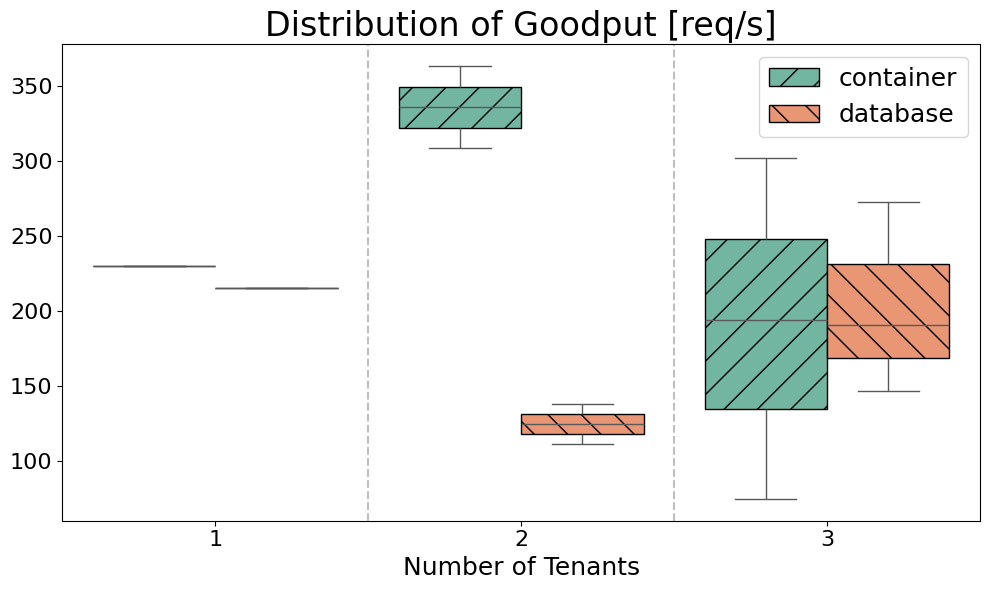

In [8]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

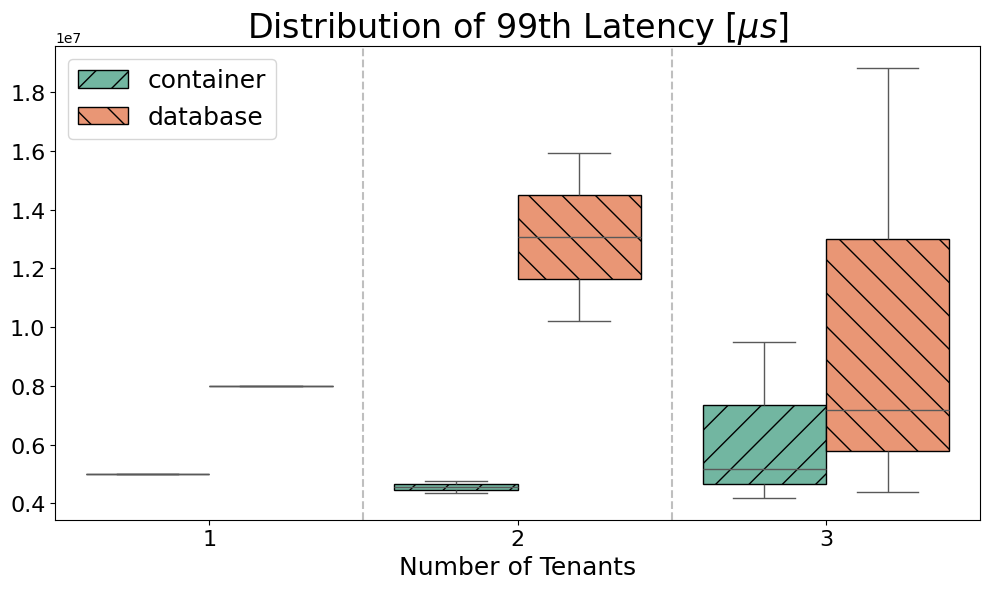

In [9]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()
plot_boxplots(df, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')


## Per Total

In [10]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants
0,1,230.076650,0,416058.000000,4988476,container,1
1,2,301.868320,0,322045.000000,6161962,container,1
0,1,672.154975,0,286638.000000,4760290,container,2
1,2,630.891630,0,295311.000000,4337573,container,2
0,1,571.233292,0,704427.333333,9509390,container,3
1,2,697.284962,0,405349.666667,7092135,container,3
0,1,215.671660,0,391956.000000,7990534,database,1
1,2,249.656654,0,374994.000000,5982455,database,1
0,1,249.383314,0,746681.500000,15928350,database,2
1,2,446.109984,0,423228.000000,5434978,database,2


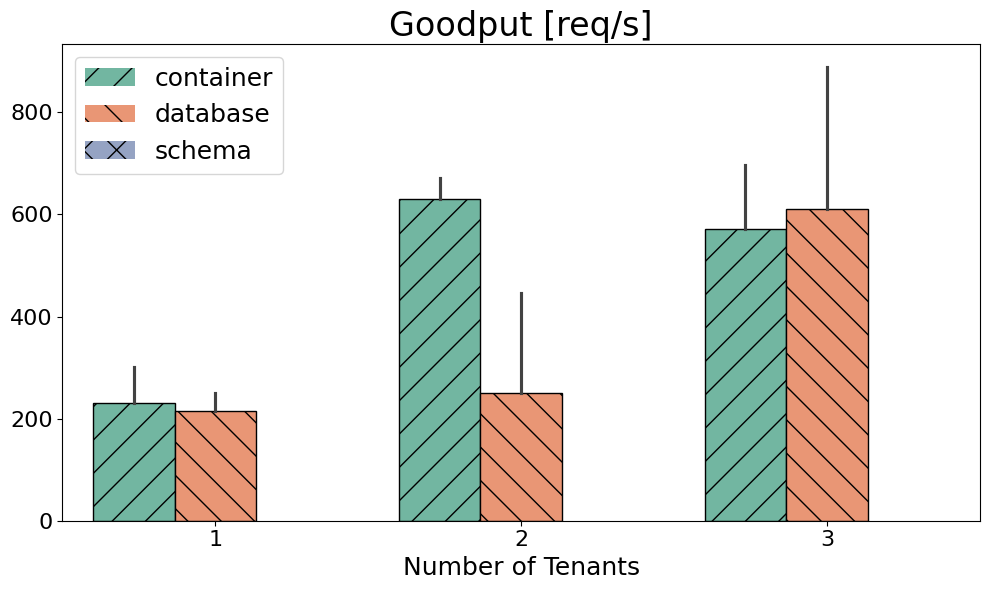

In [11]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

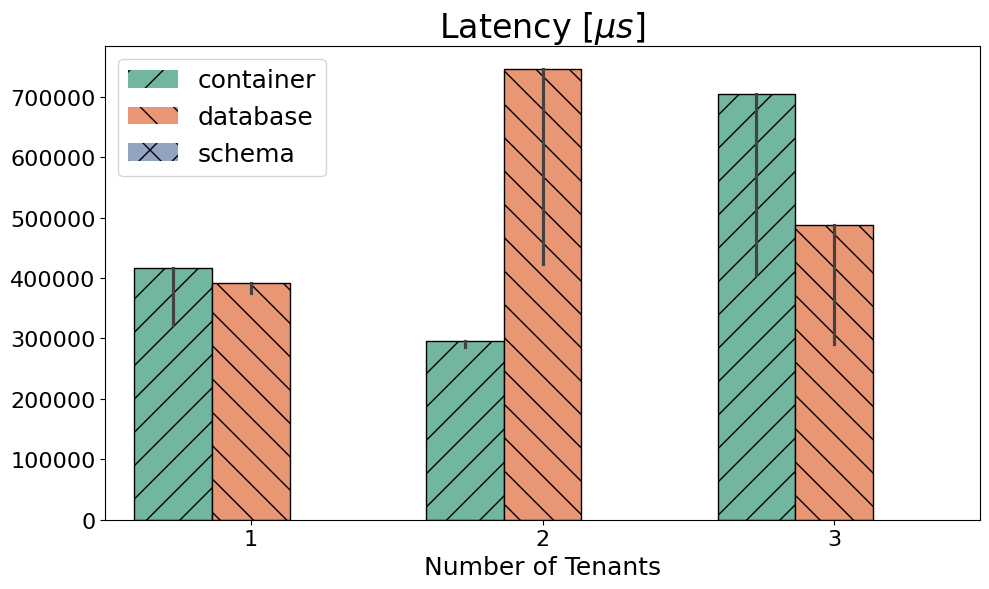

In [12]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

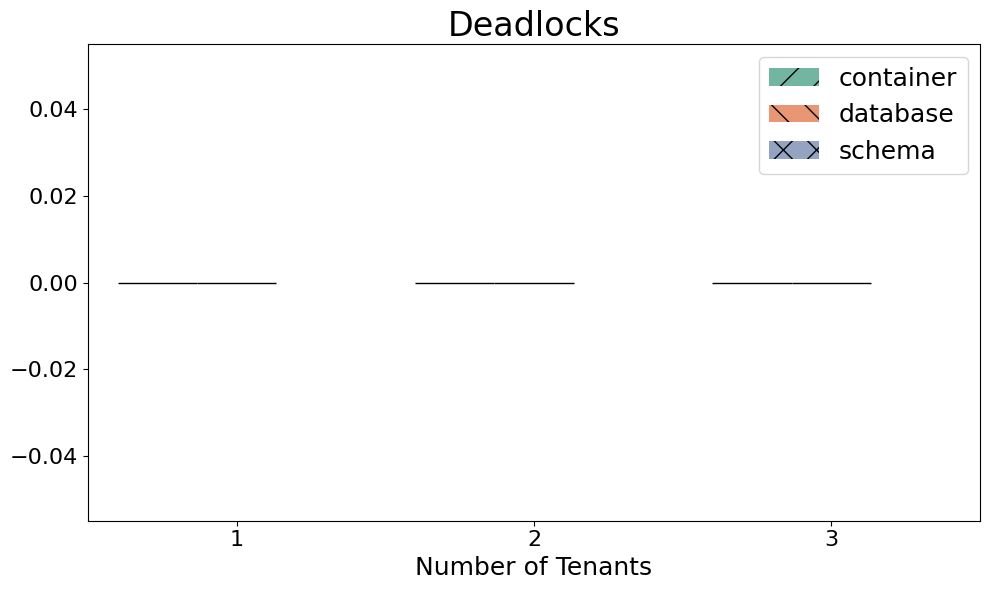

In [13]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [14]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
MySQL-1-1-65536-0-1,8506.0,4158.0,4316.0,1,1,0,1,10084,container,1
MySQL-1-1-65536-0-2,8506.0,4158.0,4316.0,1,1,0,2,10944,container,1
MySQL-1-1-65536-0-1,8868.0,4325.0,4512.0,1,1,0,1,10088,container,2
MySQL-1-1-65536-0-2,8868.0,4325.0,4512.0,1,1,0,2,11225,container,2
MySQL-1-1-65536-1-1,8651.0,4107.0,4473.0,1,1,1,1,10092,container,2
MySQL-1-1-65536-1-2,8651.0,4107.0,4473.0,1,1,1,2,11418,container,2
MySQL-1-1-65536-0-1,9084.0,4304.0,4748.0,1,1,0,1,10088,container,3
MySQL-1-1-65536-0-2,9084.0,4304.0,4748.0,1,1,0,2,10814,container,3
MySQL-1-1-65536-1-1,9186.0,4446.0,4710.0,1,1,1,1,10092,container,3
MySQL-1-1-65536-1-2,9186.0,4446.0,4710.0,1,1,1,2,11209,container,3


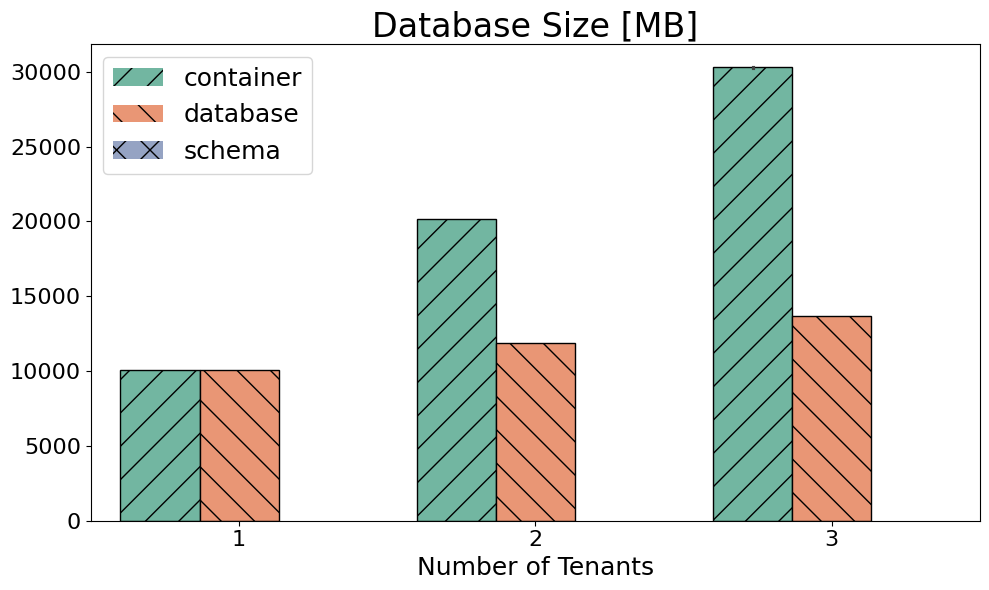

In [15]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

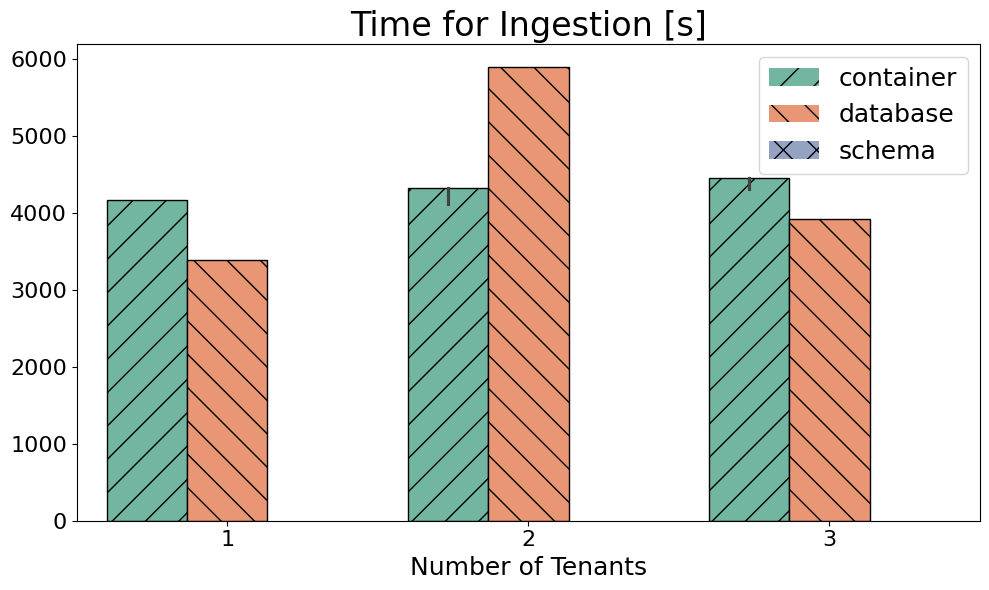

In [16]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

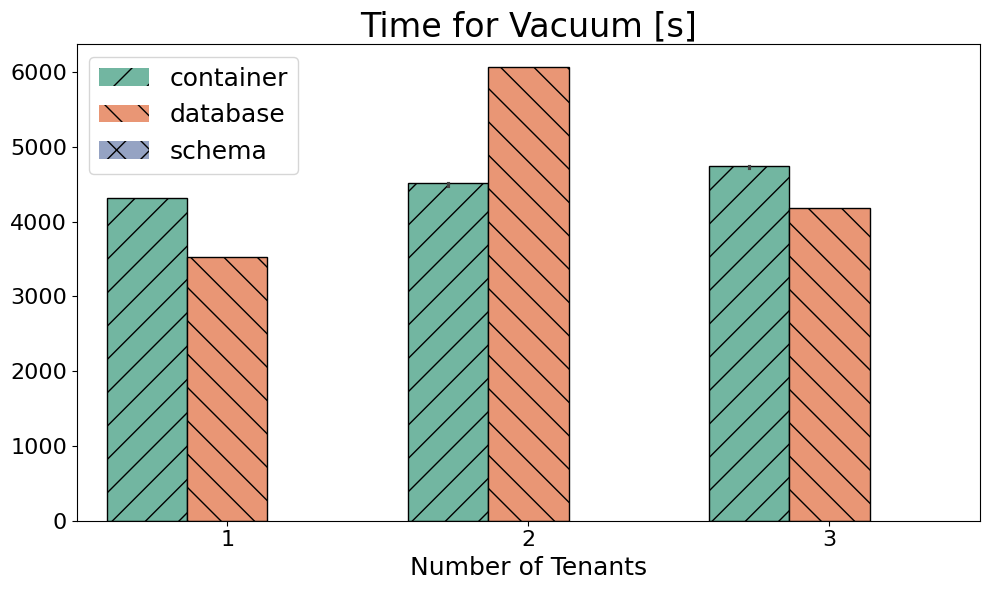

In [17]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

## Hardware Benchmarking

In [18]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Core Variance [%],type,num_tenants
0,1,1084.80,35.27,44.63,3.51,0.00,0.02,container,1
0,1,3382.10,70.65,90.09,5.44,2.35,0.16,container,2
0,1,2880.42,105.65,133.30,13.10,14.19,0.15,container,3
0,1,1093.78,35.26,44.62,4.11,0.00,0.00,database,1
0,1,1267.81,36.62,46.73,9.94,0.15,0.00,database,2
0,1,2930.42,38.19,50.00,9.66,0.12,0.04,database,3


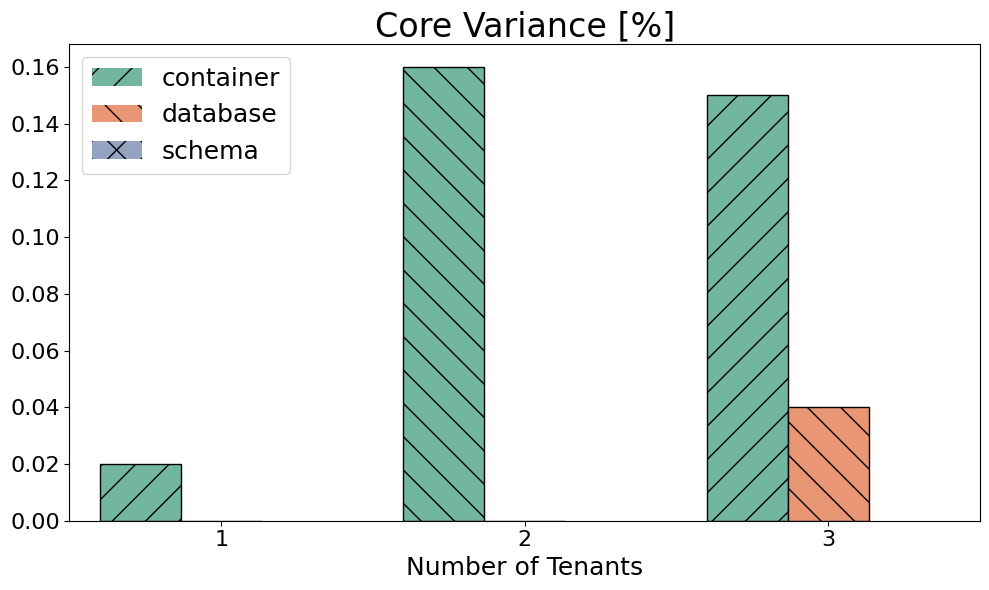

In [19]:
plot_bars(df_performance, y='Core Variance [%]', title='Core Variance [%]', estimator='max')

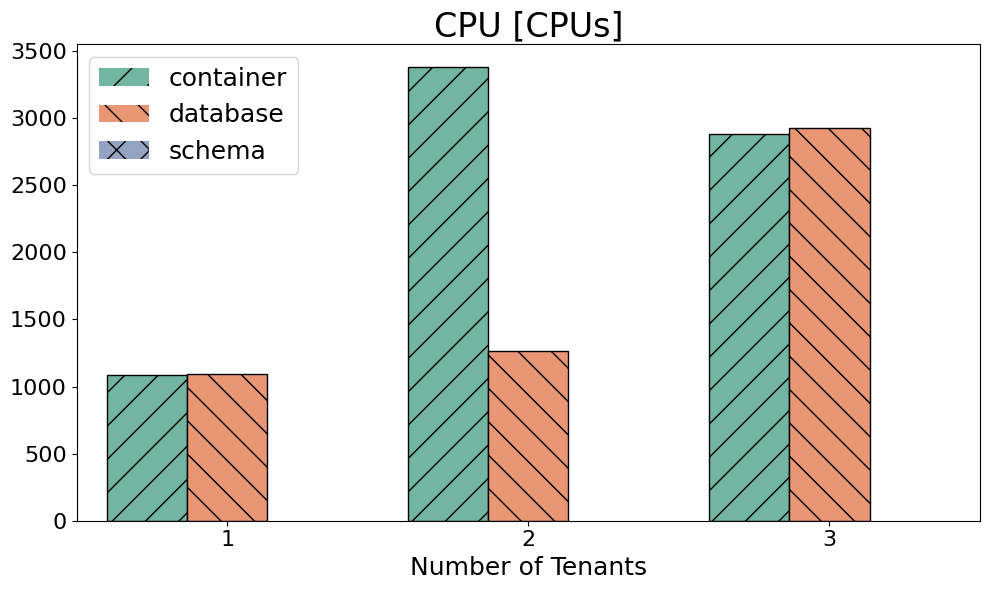

In [20]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

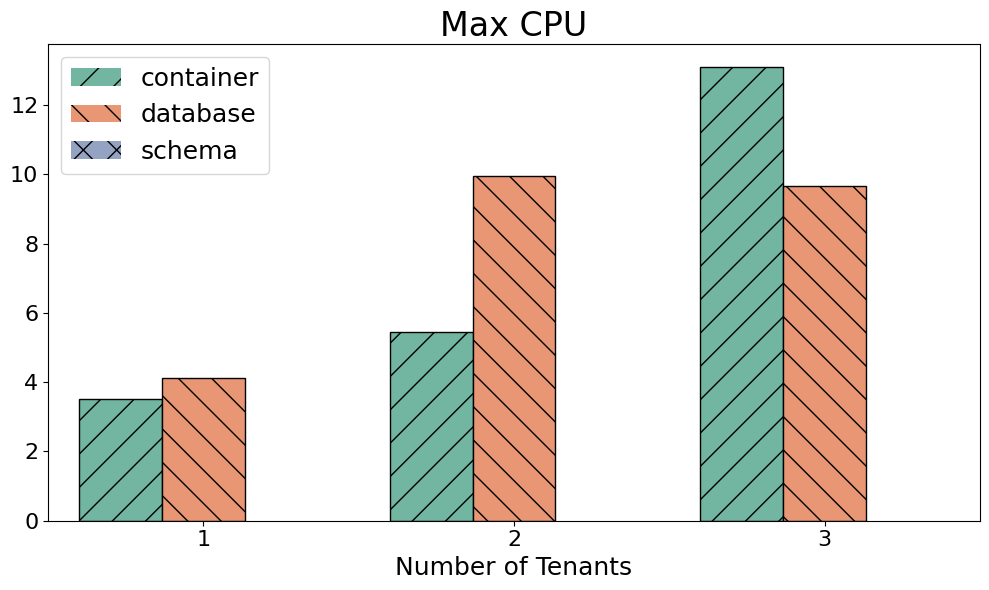

In [21]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

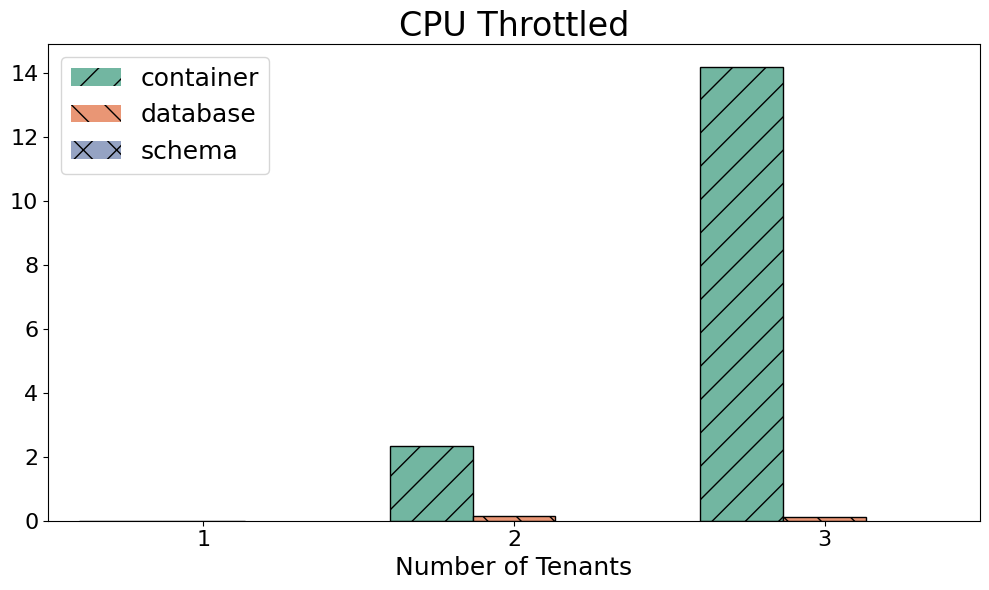

In [22]:
plot_bars(df_performance, y='CPU Throttled', title='CPU Throttled', estimator='sum')

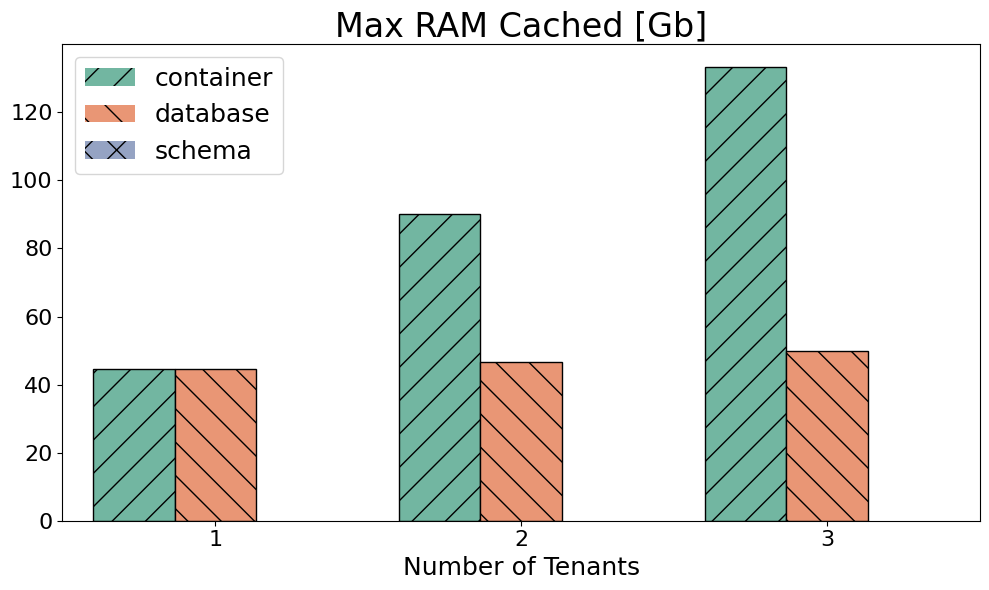

In [23]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

## Hardware Loading

In [24]:
df_performance = get_monitoring_all(codes, "stream")
#df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Core Variance [%],type,num_tenants
0,1,1084.80,35.27,44.63,3.51,0.00,0.02,container,1
1,2,1263.90,35.41,45.57,2.16,0.00,0.02,container,1
0,1,3382.10,70.65,90.09,5.44,2.35,0.16,container,2
1,2,3164.99,70.95,92.30,10.09,4.39,0.14,container,2
0,1,2880.42,105.65,133.30,13.10,14.19,0.15,container,3
1,2,3638.44,106.01,135.82,14.50,15.13,0.27,container,3
0,1,1093.78,35.26,44.62,4.11,0.00,0.00,database,1
1,2,1240.68,35.39,45.49,2.79,0.00,0.00,database,1
0,1,1267.81,36.62,46.73,9.94,0.15,0.00,database,2
1,2,2138.27,36.84,48.28,5.07,0.02,0.00,database,2


In [25]:
#plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

In [26]:
#plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

In [27]:
#plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [28]:
client = '1'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['I_Lat'] = 1./merged_df['E_Lat']
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Core Variance [%],E_Tpx,E_Lat,E_RAM
0,1,230.076650,0,416058.000000,4988476,container,1,1,1084.80,35.27,44.63,3.51,0.00,0.02,127.254784,0.047070,6.523296
1,1,672.154975,0,286638.000000,4760290,container,2,1,3382.10,70.65,90.09,5.44,2.35,0.16,119.243365,0.032117,9.513871
2,1,571.233292,0,704427.333333,9509390,container,3,1,2880.42,105.65,133.30,13.10,14.19,0.15,118.989583,0.022200,5.406846
3,1,215.671660,0,391956.000000,7990534,database,1,1,1093.78,35.26,44.62,4.11,0.00,0.00,118.308066,0.048297,6.116610
4,1,249.383314,0,746681.500000,15928350,database,2,1,1267.81,36.62,46.73,9.94,0.15,0.00,118.022407,0.032502,6.810030
5,1,609.773314,0,487369.666667,18830287,database,3,1,2930.42,38.19,50.00,9.66,0.12,0.04,124.850359,0.026461,15.966832


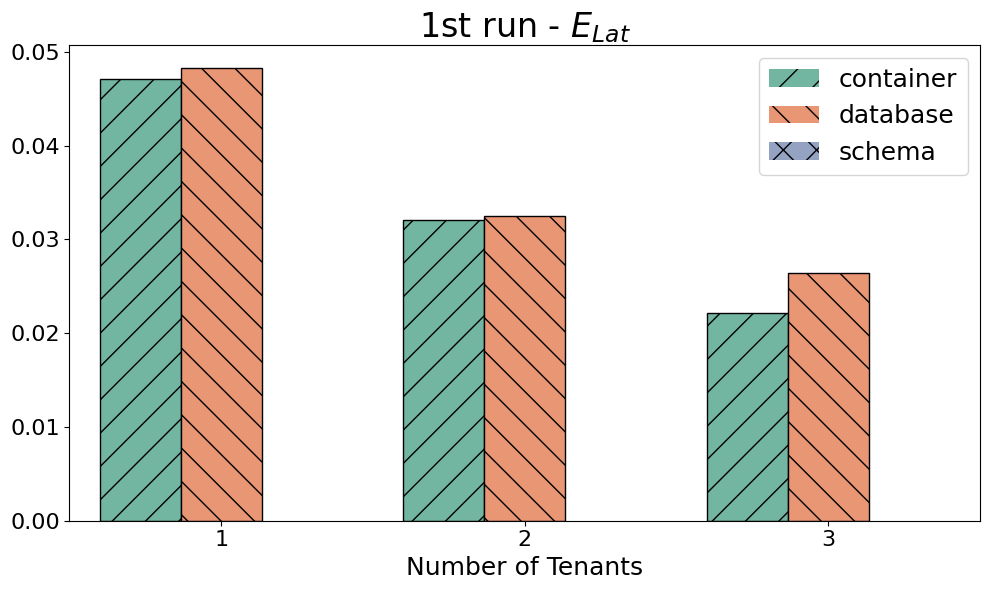

In [29]:
plot_bars(merged_df, y='E_Lat', title='1st run - $E_{Lat}$', estimator='max')

In [30]:
#plot_bars(merged_df, y='I_Lat', title='1st run - $I_{Lat}$', estimator='max')

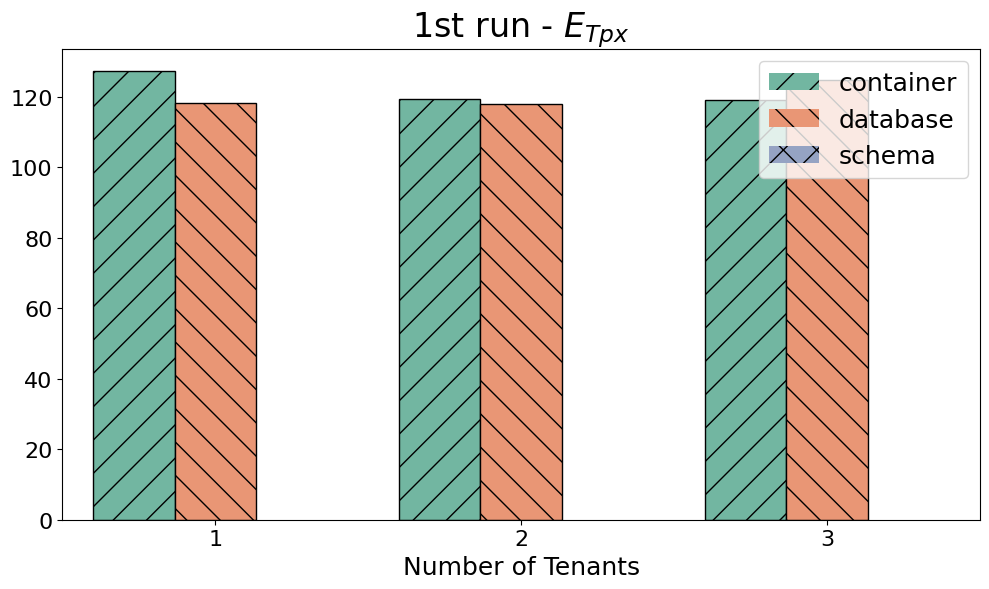

In [31]:
plot_bars(merged_df, y='E_Tpx', title='1st run - $E_{Tpx}$', estimator='max')

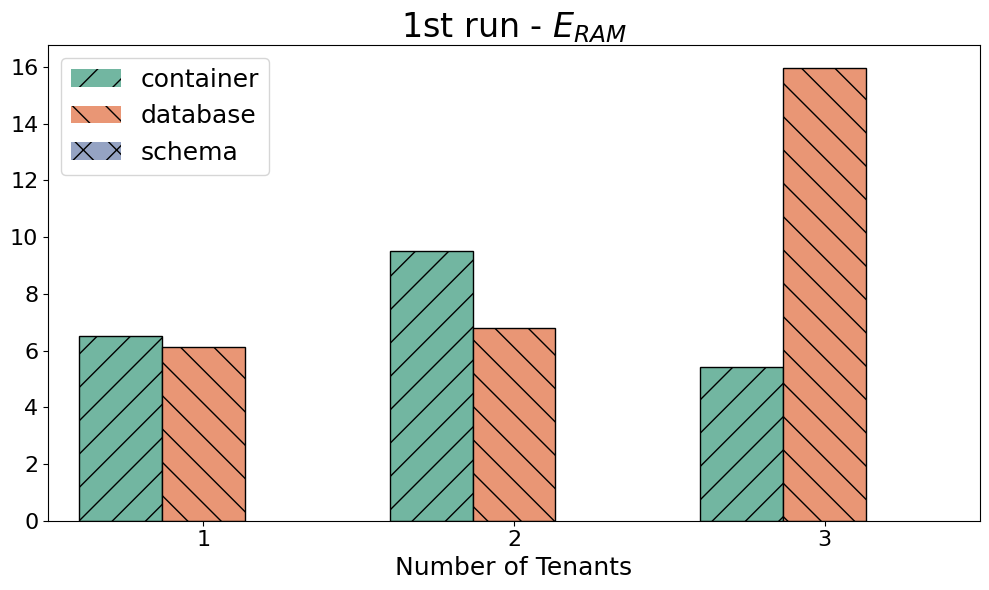

In [32]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='min')

In [33]:
client = '2'

df_performance_monitoring = get_monitoring_stream_all(codes)
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = get_performance_all(codes)
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,client_y,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Core Variance [%],E_Tpx,E_Lat,E_RAM
0,2,301.868320,0,322045.000000,6161962,container,1,2,1263.90,35.41,45.57,2.16,0.00,0.02,143.303261,0.049566,8.524945
1,2,630.891630,0,295311.000000,4337573,container,2,2,3164.99,70.95,92.30,10.09,4.39,0.14,119.600687,0.032710,8.892060
2,2,697.284962,0,405349.666667,7092135,container,3,2,3638.44,106.01,135.82,14.50,15.13,0.27,114.986362,0.026039,6.577539
3,2,249.656654,0,374994.000000,5982455,database,1,2,1240.68,35.39,45.49,2.79,0.00,0.00,120.735397,0.046362,7.054441
4,2,446.109984,0,423228.000000,5434978,database,2,2,2138.27,36.84,48.28,5.07,0.02,0.00,125.178761,0.033242,12.109392
5,2,888.919962,0,291193.333333,4738320,database,3,2,4394.27,38.61,53.10,12.59,0.48,0.05,121.374421,0.027955,23.023050


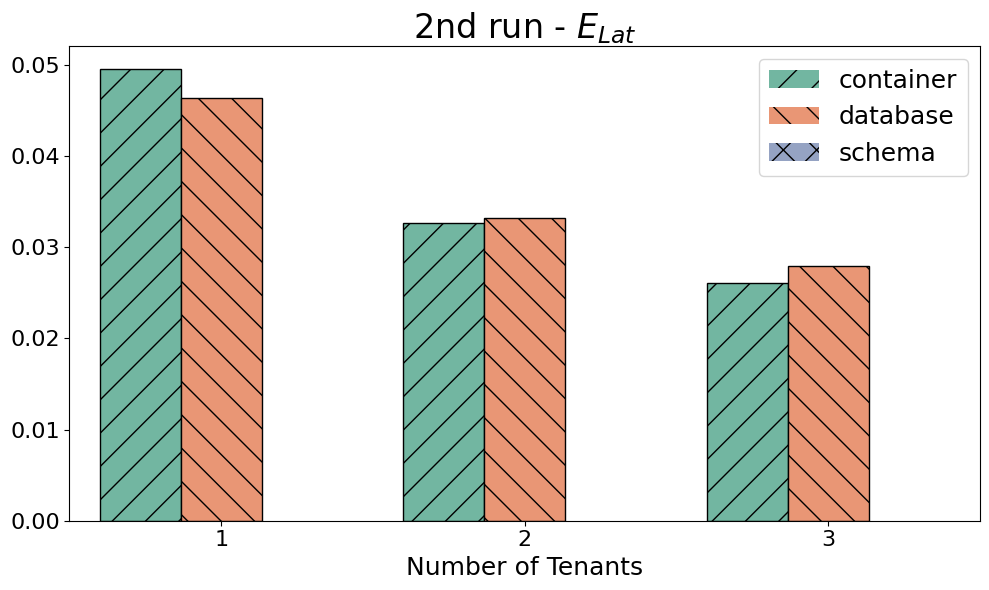

In [34]:
plot_bars(merged_df, y='E_Lat', title='2nd run - $E_{Lat}$', estimator='max')

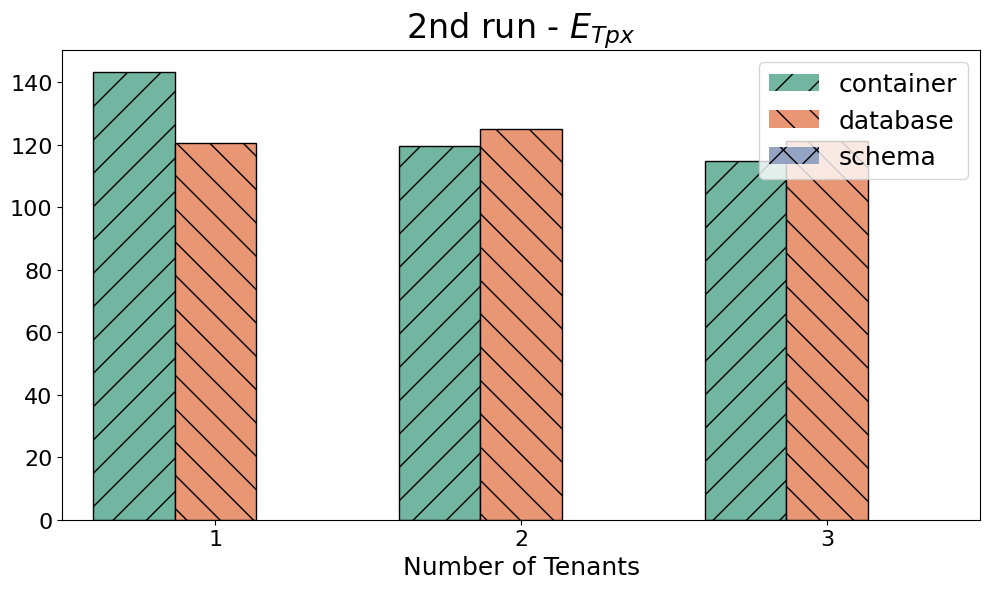

In [35]:
plot_bars(merged_df, y='E_Tpx', title='2nd run - $E_{Tpx}$', estimator='max')

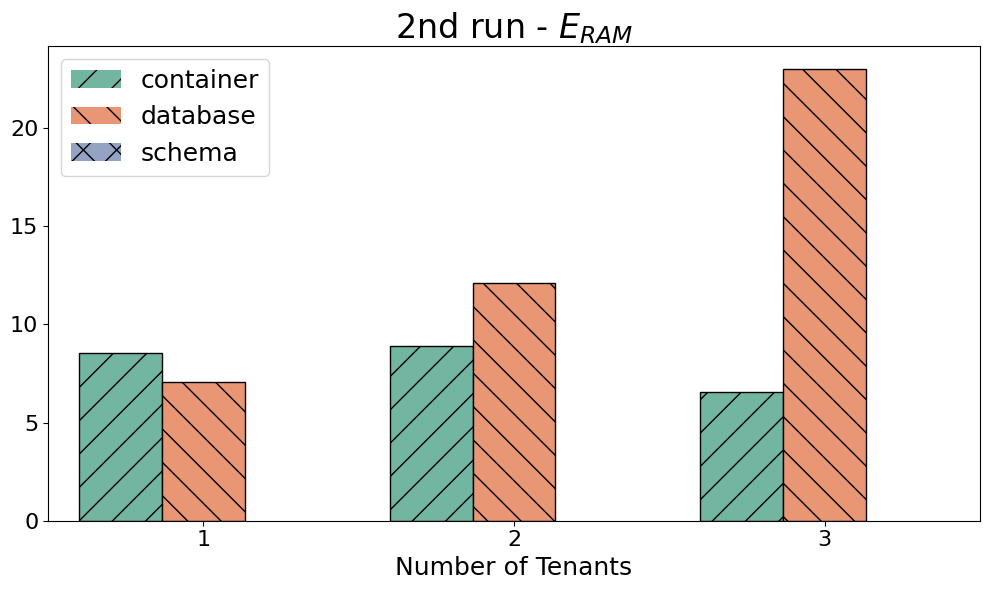

In [36]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [37]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [38]:
#zip_all_results()